# Segmentation Exercise

In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. Below is the code for setting up a segmentation network and training it. The network isn't very good, so the exercise is to improve the quality of the segmentation by improving the network. 

The data being used here is derived from the Sunnybrook Dataset (https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac images, filtered to contain only left ventricle myocardium segmentations and reduced in XY dimensions.

PyTorch documentation can be found here: https://pytorch.org/docs/stable/index.html

First we load the data from the repo and setup libraries:

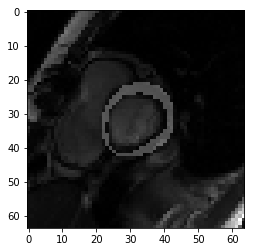

In [1]:
%matplotlib inline

# download dataset if in Colab
![ -f scd_lvsegs.npz ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz

import torch, torch.nn as nn, torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

data=np.load('scd_lvsegs.npz') # load all the data from the archive

images=data['images'] # images in BHW array order
segs=data['segs'] # segmentations in BHW array order
caseIndices=data['caseIndices'] # the indices in `images` for each case

images=images.astype(np.float32)/images.max() # normalize images

plt.imshow(images[13]+segs[13]*0.25,cmap='gray') # show image 13 with segmentation

We have only 420 images so for the sake of this exercise we will only do a division between train and test data, choosing to retain the last 6 cases as our test set. Typically you would want to have a training dataset, a validation dataset checked periodically during training to ensure the network continues to produce good results for data is isn't trained on, and a test dataset used to validate the training after the fact.

In [2]:
testIndex=caseIndices[-6,0] # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
trainImages,trainSegs=images[:testIndex],segs[:testIndex]
testImages,testSegs=images[testIndex:],segs[testIndex:]

We define our loss function, in this case implementing the binary Dice loss based on segmentation overlap:

In [3]:
class DiceLoss(nn.modules.loss._Loss):
    '''This defines the binary dice loss function used to assess segmentation overlap.'''
    def forward(self, source, target, smooth=1e-5):
        batchsize = target.size(0)
        source=source.sigmoid() # apply sigmoid to the source logits to impose it onto the [0,1] interval
        
        # flatten target and source arrays to 2D BV arrays
        tsum=target.view(batchsize, -1) 
        psum=source.view(batchsize, -1)
        
        intersection=psum*tsum
        sums=psum+tsum 

        # compute the score, the `smooth` value is used to smooth results and prevent divide-by-zero
        score = 2.0 * (intersection.sum(1) + smooth) / (sums.sum(1) + smooth)
        
        # `score` is 1 for perfectly identical source and target, 0 for entirely disjoint
        return 1 - score.sum() / batchsize

We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

In [29]:
class SegNet(nn.Module):
    '''
    My solution is a simple autoencoder which has a downsampling path with three layers using strided convolutions
    to reduce dimensions. After the bottom layer the decoding path upsamples using strided transpose convolutions. 
    Dropout is added in places to reduce overfitting.
    '''
    def __init__(self):
        super().__init__()
        
        self.model=nn.Sequential(
            # layer 1
            nn.Conv2d(1,4,3,2,1),
            nn.InstanceNorm2d(4),
            nn.PReLU(),
            # layer 2
            nn.Conv2d(4,8,3,2,1),
            nn.InstanceNorm2d(8),
            nn.PReLU(),
            nn.Dropout2d(),
            # layer 3
            nn.Conv2d(8,16,3,2,1),
            nn.InstanceNorm2d(16),
            nn.PReLU(),
            # bottom layer
            nn.Conv2d(16,16,3,1,1),
            nn.Dropout2d(),
            # layer 5
            nn.ConvTranspose2d(16,8,3,2,1,1),
            nn.InstanceNorm2d(8),
            nn.PReLU(),
            # layer 6
            nn.ConvTranspose2d(8,4,3,2,1,1),
            nn.InstanceNorm2d(4),
            nn.PReLU(),
            nn.Dropout2d(),
            # layer 7
            nn.ConvTranspose2d(4,2,3,2,1,1),
            nn.InstanceNorm2d(2),
            nn.PReLU(),
            # layer 8: output
            nn.Conv2d(2,1,3,1,1),
        )
        
    def forward(self,x):
        return self.model(x)

The network is now trained. We can load the whole dataset into memory at once but typically this isn't possible. To create batches for each train step, some form of data loader is generally used which samples from existing data and sometimes applies transformations to the data before being forward passed through the network. 

250 0.5471161603927612
500 0.45136427879333496
750 0.4240427613258362
1000 0.42031270265579224
1250 0.424308717250824
1500 0.42257338762283325
1750 0.41595321893692017
2000 0.4095190167427063
2250 0.4132140278816223
2500 0.39869219064712524
2750 0.3995290994644165
3000 0.40850716829299927
3250 0.40492457151412964
3500 0.408191442489624
3750 0.39821499586105347
4000 0.4070730209350586
4250 0.4052746891975403
4500 0.399929940700531
4750 0.4086523652076721
5000 0.40057891607284546
CPU times: user 6min 58s, sys: 23 s, total: 7min 21s
Wall time: 7min 21s


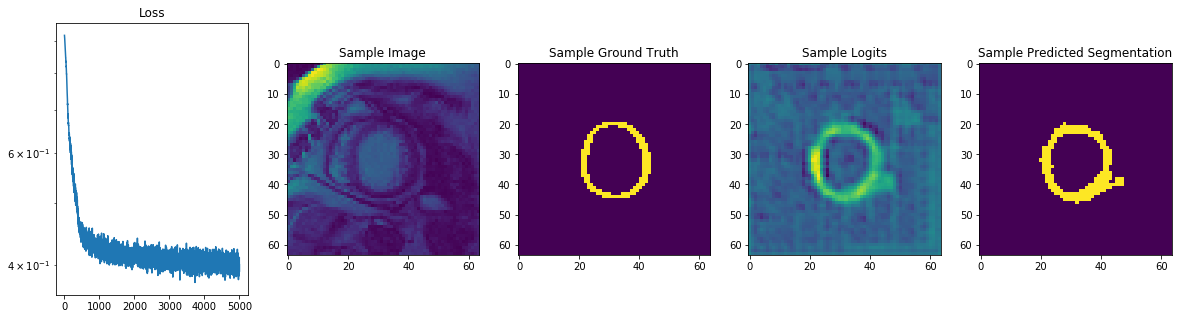

In [31]:
%%time
# store the training data as tensors
trainTensor=torch.from_numpy(trainImages[:,None])
segTensor=torch.from_numpy(trainSegs[:,None].astype(np.float32))

# create network object
net=SegNet()

# choose a device and move the net and tensors to its memory
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net=net.to(device)
trainTensor=trainTensor.to(device)
segTensor=segTensor.to(device)

# define optimizer and loss function
opt=torch.optim.Adam(net.parameters(),0.005)
loss=DiceLoss()

trainSteps=5000 # changed from 100
losses=[]

# run through training steps
for t in range(1,trainSteps+1):
    opt.zero_grad()
    pred=net(trainTensor)
    lossval=loss(pred,segTensor)
    lossval.backward()
    opt.step()
        
    losses.append(lossval.item())
    if t%(trainSteps//20)==0:
        print(t,lossval.item())    
    

# sample an image from the training data and look at the segmentation the network predicted for it
sample=10
predSample=pred[sample,0].cpu().data.numpy()
fig,ax=plt.subplots(1,5,figsize=(20,5))
ax[0].set_title('Loss')
ax[0].semilogy(losses)
ax[1].set_title('Sample Image')
ax[1].imshow(trainImages[10])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(trainSegs[10])
ax[3].set_title('Sample Logits')
ax[3].imshow(predSample)
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(predSample>0.5)

Now we apply the test data to the network. These images were never seen by the network so how well the task is performed is an indicator of how generalized and robust the network is:

Test loss: 0.34494179487228394


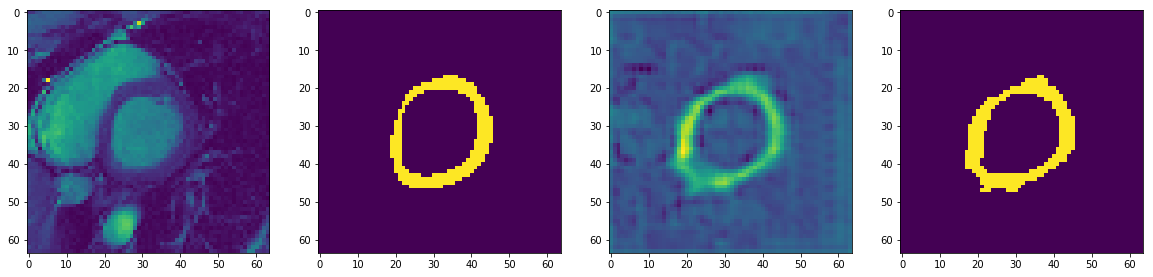

In [32]:
testTensor=torch.from_numpy(testImages[:,None]).to(device)
testSegTensor=torch.from_numpy(testSegs[:,None]).to(device).float()

net.to(device)
net.eval() # use the network in evaluation mode
pred=net(testTensor)
testloss=loss(pred,testSegTensor).item() # calculate test loss

pred=pred.to('cpu').data.numpy()

seg=pred>0.5

fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(testImages[10])
ax[1].imshow(testSegs[10])
ax[2].imshow(pred[10,0])
ax[3].imshow(seg[10,0])

print('Test loss:',testloss)

The loss over the images of the test set is higher than the last loss value from training. This implies the network has become overfitted to the images it was trained with and so does a poorer job on images it hasn't seen before. What simple ways can we tackle this problem?

----
## Alternative Solution With Unet
Below are two implementations of the unet architecture. They are broadly equivalent though the second does work better. Tweaking the learning rate or the number of timesteps would also improve performance.

In [34]:
def getDownBlock(inChannels,outChannels):
    '''Convenience function for creating a downsampling path block.'''
    return torch.nn.Sequential(
        nn.Conv2d(inChannels,outChannels,3,2,1),
        nn.InstanceNorm2d(outChannels),
        nn.Dropout2d(0.15),
        nn.PReLU()
    )


def getUpBlock(inChannels,outChannels):
    '''Convenience function for creating a upsampling path block.'''
    return torch.nn.Sequential(
        nn.ConvTranspose2d(inChannels,outChannels,3,2,1,1),
        nn.InstanceNorm2d(outChannels),
        nn.Dropout2d(0.15),
        nn.PReLU()
    )


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.down1=getDownBlock(1,4)
        self.down2=getDownBlock(4,8)
        self.down3=getDownBlock(8,16)
        self.down4=getDownBlock(16,32)
        self.down5=getDownBlock(32,64)
        
        self.bottom=nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.InstanceNorm2d(64),
            nn.PReLU(),
        )
        
        self.up1=getUpBlock(128,32)
        self.up2=getUpBlock(64,16)
        self.up3=getUpBlock(32,8)
        self.up4=getUpBlock(16,4)
        self.up5=getUpBlock(8,4)
        self.final=nn.Conv2d(4,1,3,1,1)
        
    def forward(self,x):
        d1=self.down1(x)
        d2=self.down2(d1)
        d3=self.down3(d2)
        d4=self.down4(d3)
        d5=self.down5(d4)
        b=self.bottom(d5)
        u1=self.up1(torch.cat([b,d5],1))
        u2=self.up2(torch.cat([u1,d4],1))
        u3=self.up3(torch.cat([u2,d3],1))
        u4=self.up4(torch.cat([u3,d2],1))
        u5=self.up5(torch.cat([u4,d1],1))
        
        return self.final(u5)
        
net=UNet()
net(torch.rand((2,1,64,64))).shape

torch.Size([2, 1, 64, 64])

Below is an alternative implementation of the unet architecture:

In [29]:
class UnetBlock(nn.Module):
    '''
    This unet implementation is defined with blocks containing the down and up path for each level of the network.
    Recall that unet looks something like this where [] is a block of layers (convolutions, activation, etc.):
    
    ->[]-------------->+[]->   This class implements one   -->[encode]--------->+->[decode]-->
       |               |       level of this structure            |             ^
       \->[]----->+[]->/       where a subblock is the            |             |
           |      |            bottom or another layer:           \->[subblock]-/
           \->[]->/
    '''
    def __init__(self,inChannels,outChannels,subblock):
        super().__init__()
        self.encode=nn.Conv2d(inChannels,outChannels,3,2,1)
        self.eIN=nn.InstanceNorm2d(outChannels)
        self.eDrop=nn.Dropout2d(0.15)
        self.eAct=nn.PReLU()
        
        self.decode=nn.ConvTranspose2d(outChannels*2,inChannels,3,2,1,1)
        self.dIN=nn.InstanceNorm2d(inChannels)
        self.dDrop=nn.Dropout2d(0.15)
        self.dAct=nn.PReLU()
        
        # sublock is either another instance of UnetBlock or a Sequential instance
        self.subblock=subblock
        
    def forward(self,x):
        #encode stage
        enc=self.encode(x)
        enc=self.eIN(enc)
        enc=self.eDrop(enc)
        enc=self.eAct(enc)
        
        # pass through subblock and concat
        sub=self.subblock(enc)
        sub=torch.cat([enc,sub],1)
        
        #decode stage
        dec=self.decode(sub)
        dec=self.dIN(dec)
        dec=self.dDrop(dec)
        dec=self.dAct(dec)
        
        return dec
    

class UNet(nn.Module):
    '''The network is built from the bottom up using the blocks to define each layer added onto the previous.'''
    def __init__(self):
        super().__init__()
        # bottom subblock
        net=nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.InstanceNorm2d(64),
            nn.PReLU(),
        )

        # build the unet structure from the bottom up
        net=UnetBlock(32,64,net)
        net=UnetBlock(16,32,net)
        net=UnetBlock(8,16,net)
        net=UnetBlock(4,8,net)

        # final top-level structure omits dropout and applies sigmoid to the output
        self.model=nn.Sequential(
            nn.Conv2d(1,4,3,1,1),
            nn.InstanceNorm2d(4),
            nn.PReLU(),
            net,
            nn.Conv2d(4,1,3,1,1),
        )
        
    def forward(self,x):
        return self.model(x)

50 0.6575040817260742
100 0.5183404684066772
150 0.44449591636657715
200 0.3906570076942444
250 0.3438279628753662
300 0.28262627124786377
350 0.251448392868042
400 0.23460686206817627
450 0.22435683012008667
500 0.21638506650924683
550 0.21291416883468628
600 0.1983811855316162
650 0.19302690029144287
700 0.1944071650505066
750 0.18392819166183472
800 0.1732398271560669
850 0.1748104691505432
900 0.16766357421875
950 0.174940288066864
1000 0.15855079889297485
CPU times: user 2min 29s, sys: 3.94 s, total: 2min 33s
Wall time: 2min 33s


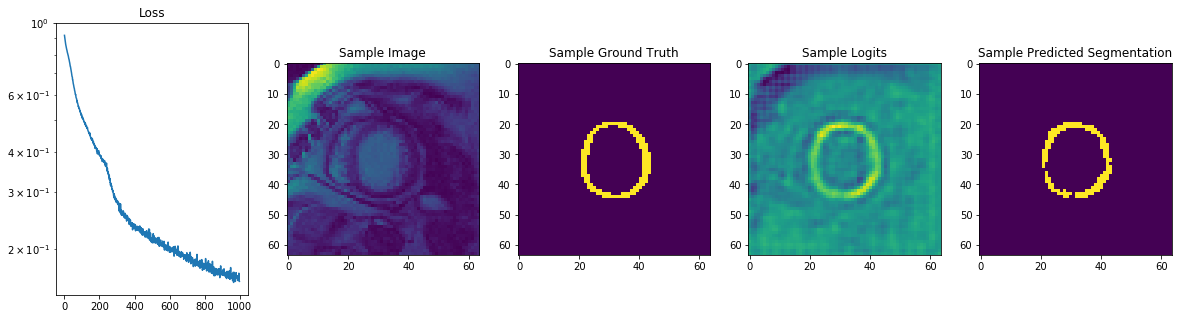

In [35]:
%%time
# store the training data as tensors
trainTensor=torch.from_numpy(trainImages[:,None])
segTensor=torch.from_numpy(trainSegs[:,None].astype(np.float32))

# create network object
net=UNet()

# choose a device and move the net and tensors to its memory
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net=net.to(device)
trainTensor=trainTensor.to(device)
segTensor=segTensor.to(device)

# define optimizer and loss function
opt=torch.optim.Adam(net.parameters(),0.005)
loss=DiceLoss()

trainSteps=1000 # changed from 100
losses=[]

# run through training steps
for t in range(1,trainSteps+1):
    opt.zero_grad()
    net.train()
    pred=net(trainTensor)
    lossval=loss(pred,segTensor)
    lossval.backward()
    opt.step()
        
    losses.append(lossval.item())
    if t%(trainSteps//20)==0:
        print(t,lossval.item())    
    

# sample an image from the training data and look at the segmentation the network predicted for it
sample=10
predSample=pred[sample,0].cpu().data.numpy()
fig,ax=plt.subplots(1,5,figsize=(20,5))
ax[0].set_title('Loss')
ax[0].semilogy(losses)
ax[1].set_title('Sample Image')
ax[1].imshow(trainImages[10])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(trainSegs[10])
ax[3].set_title('Sample Logits')
ax[3].imshow(predSample)
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(predSample>0.5)

Test loss: 0.25177717208862305


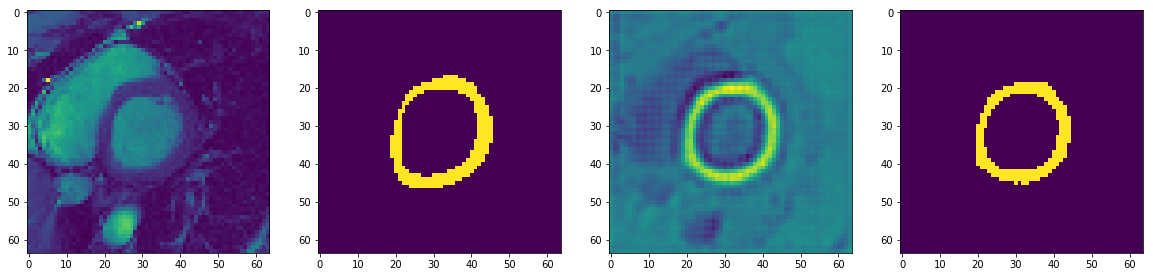

In [36]:
testTensor=torch.from_numpy(testImages[:,None]).to(device)
testSegTensor=torch.from_numpy(testSegs[:,None]).to(device).float()

net.to(device)
net.eval()
pred=net(testTensor)
testloss=loss(pred,testSegTensor).item() # calculate test loss

pred=pred.to('cpu').data.numpy()

seg=pred>0.5

fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(testImages[10])
ax[1].imshow(testSegs[10])
ax[2].imshow(pred[10,0])
ax[3].imshow(seg[10,0])

print('Test loss:',testloss)